# EPS 229 Project

## Henry Peterson 2018

Diffusion equation:

$$ \frac{\partial E}{\partial t} = S - L + \frac{p_s}{g}D\nabla^2 E - F_s$$

In [27]:
################################################################################
### IMPORTS AND STYLES
################################################################################
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import climt
from metpy.calc import moist_lapse
from metpy.units import units
from scipy.integrate import quadrature
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp2d
from scipy.optimize import curve_fit
from time import clock
from matplotlib import animation, rc

rc('animation', html='html5')
rc('lines', linewidth=2, color='b', markersize=10)
rc('axes', titlesize=20, labelsize=16, xmargin=0.05, ymargin=0.05, linewidth=1.5)
rc('axes.spines', top=False, right=False)
rc('xtick', labelsize=13)
rc('xtick.major', size=5, width=1.5)
rc('ytick', labelsize=13)
rc('ytick.major', size=5, width=1.5)
rc('legend', fontsize=14)

In [28]:
################################################################################
### CONSTANTS 
################################################################################
ps = 98000 #Pa = kg/m/s2
cp = 1005 #J/kg/K
g = 9.81 #m/s2
D = 1.06e6 #m2/s
Re = 6.371e6 #m 
RH = 0.8 #0-1 
S0 = 1365 #J/m2/s
R = 287.058 #J/kg/K
Lv = 2257000 #J/kg
sig = 5.67e-8 #J/s/m2/K4

# numerical variables
# dlat = 0.5
dlat = 1.5
dy = np.pi*Re*dlat/180
dtmax = 0.5*dy**2/D
# dt = dtmax
dt = 1.0 * dtmax
# max_iters = 5e4
max_iters = 1e5
tolerance = 0.001 # K
t_final = max_iters*dt
# Nplot = 500
Nplot = 100
frames = int(t_final / dt / Nplot)
anim_length = 8000
print("dtmax:      {:.2f} s / {:.4f} days".format(dtmax, dtmax/60/60/24))
print("df:         {:.2f} s / {:.4f} days".format(dt, dt/60/60/24))
print("dy:         {:.2f} m".format(dy))
print("iterations: {}".format(int(max_iters)))
print("Time:       {:.2f} s / {:.0f} days".format(t_final, t_final/60/60/24))
print("frames:     {}".format(frames))

# xvals --- important to have set up early
lats = np.linspace(-90, 90, int(180/dlat))

dtmax:      13122.50 s / 0.1519 days
df:         13122.50 s / 0.1519 days
dy:         166792.39 m
iterations: 100000
Time:       1312250063.72 s / 15188 days
frames:     1000


In [29]:
################################################################################
# INSOLATION
################################################################################
# insolation_type = 'annual_mean'
insolation_type = 'annual_mean_clark'
# insolation_type = 'perturbed'
# insolation_type = 'summer_mean'

if insolation_type == 'annual_mean':
    obliquity = np.deg2rad(23.4)
    eccentricity = 0.0167
    Q0 = S0/4
    Q = Q0 / np.sqrt(1 - eccentricity**2)
    p2 = lambda y: (3*y**2 - 1)/2
    p4 = lambda y: (35*y**4 - 30*y**2 + 3)/8
    p6 = lambda y: (231*y**6 - 315*y**4 + 105*y**2 - 5)/16
    cosB = np.cos(obliquity)
    s_approx = lambda y: 1 - 5/8*p2(cosB)*p2(y) - 9/64*p4(cosB)*p4(y) - 65/1024*p6(cosB)*p6(y)
    get_S = lambda lat: Q * s_approx(np.sin(np.deg2rad(lat)))
elif insolation_type == 'annual_mean_clark':
    get_S = lambda lat: S0*np.cos(np.deg2rad(lat))/np.pi
elif insolation_type == 'perturbed':
    get_S_control = lambda lat: S0*np.cos(np.deg2rad(lat))/np.pi
    ############################################################################
    ###CHANGE VALS
    lat0 = 15; sigma = 4.94
#     lat0 = 60; sigma = 9.89
#     M = 5
#     M = 10
#     M = 15
    M = 18
    ###
    ############################################################################
    func = lambda y: 0.5 * np.exp(-(y - np.deg2rad(lat0))**2 / (2*np.deg2rad(sigma)**2)) * np.cos(y)
    M0, er = quadrature(func, -np.pi/2, np.pi/2, tol=1e-16, rtol=1e-16, maxiter=1000)
    get_dS = lambda lat: - M/M0 * np.exp(-(lat - lat0)**2 / (2*sigma**2))
    get_S = lambda lat: get_S_control(lat) + get_dS(lat)
elif insolation_type == 'summer_mean':
    dec = np.deg2rad(23.45/2)
    get_h0 = lambda lat: np.arccos( -np.tan(np.deg2rad(lat)) * np.tan(dec))
    def get_S(lat_array):
        ss = np.zeros(len(lat_array))
        for i in range(len(lat_array)):
            lat = lat_array[i]
            if lat >= 90 - np.rad2deg(dec):
                h0 = np.pi
            elif lat <= -90 + np.rad2deg(dec):
                h0 = 0
            else:
                h0 = get_h0(lat)
            s = S0 / np.pi * (h0*np.sin(np.deg2rad(lat))*np.sin(dec) + np.cos(np.deg2rad(lat))*np.cos(dec)*np.sin(h0))
            ss[i] = s
        return ss
    
S = get_S(lats)

In [30]:
################################################################################
### HUMIDITY
################################################################################
def humidsat(t,p):
    """
    FROM BOOS:
    % function [esat,qsat,rsat]=humidsat(t,p)
    %  computes saturation vapor pressure (esat), saturation specific humidity (qsat),
    %  and saturation mixing ratio (rsat) given inputs temperature (t) in K and
    %  pressure (p) in hPa.
    %
    %  these are all computed using the modified Tetens-like formulae given by
    %  Buck (1981, J. Appl. Meteorol.)
    %  for vapor pressure over liquid water at temperatures over 0 C, and for
    %  vapor pressure over ice at temperatures below -23 C, and a quadratic
    %  polynomial interpolation for intermediate temperatures.
    """
    tc=t-273.16;
    tice=-23;
    t0=0;
    Rd=287.04;
    Rv=461.5;
    epsilon=Rd/Rv;

    # first compute saturation vapor pressure over water
    ewat=(1.0007+(3.46e-6*p))*6.1121*np.exp(17.502*tc/(240.97+tc))
    eice=(1.0003+(4.18e-6*p))*6.1115*np.exp(22.452*tc/(272.55+tc))
    # alternatively don't use enhancement factor for non-ideal gas correction
    #ewat=6.1121.*exp(17.502.*tc./(240.97+tc));
    #eice=6.1115.*exp(22.452.*tc./(272.55+tc));
    eint=eice+(ewat-eice)*((tc-tice)/(t0-tice))**2

    esat=eint
    esat[np.where(tc<tice)]=eice[np.where(tc<tice)]
    esat[np.where(tc>t0)]=ewat[np.where(tc>t0)]

    # now convert vapor pressure to specific humidity and mixing ratio
    rsat=epsilon*esat/(p-esat);
    qsat=epsilon*esat/(p-esat*(1-epsilon));
#     return esat, qsat, rsat
    return qsat

In [31]:
################################################################################
# DATASETS 
################################################################################
T_dataset = np.arange(100, 400, 1e-3)
q_dataset = humidsat(T_dataset, ps/100)
E_dataset = cp*T_dataset + RH*q_dataset*Lv

In [32]:
################################################################################
# FEEDBACKS
################################################################################
# albedo_feedback = True
albedo_feedback = False

In [33]:
################################################################################
# ALBEDO
################################################################################
if albedo_feedback == True:
    a1 = 0.8
    a2 = 0.1 
    init_alb = 0*lats + a2
    init_alb[np.where(init_temp <= 273.16)] = a1
else:
#     init_alb = 0.2725 * np.ones(len(lats))
    init_alb = (0.3129-0.1959) * np.ones(len(lats))
    
# 67 / 342
# .19590643274853801169

# 107 / 342
# .31286549707602339181

alb = init_alb

In [34]:
################################################################################
# INITIAL CONDITIONS
################################################################################
# init_condition = 'parabola'
# init_condition = 'cos2'
init_condition = 'triangle'
# init_condition = 'top-hat'

if init_condition == 'parabola':
    f0 = 270
    f1 = 305
    f2 = 270
    init_temp = f0 + (f1-f0)/90*(lats + 90) + (f2-2*f1+f0)/90/180*(lats + 90)*(lats + 0)
elif init_condition == 'cos2':
    init_temp = 270 + 35 * np.cos(np.deg2rad(lats))**2
elif init_condition == 'triangle':
    init_temp = (305 - 35/90*np.abs(lats))
#     init_temp = (305 - 35/90*np.abs(lats))
elif init_condition == 'top-hat':
    init_temp = 0*lats + 270
    init_temp[int(1/3*len(lats)):int(2/3*len(lats))] = 305
    

In [35]:
################################################################################
# OLR
################################################################################
# olr_type = 'gray'
olr_type = 'full'
# olr_type = 'linear'
# olr_type = 'shell_somerville'

if olr_type == 'gray':
    ''' GRAY RADIATION '''
    # optical_depth = 1.5
    # integrand = lambda tau: tau**(4*R/cp) * np.exp(-tau)
    # integral, error = quadrature(integrand, 0, optical_depth, tol=1e-16, rtol=1e-16, maxiter=1000)
    # L = lambda T: (1-alb)*sig*T**4*np.exp(-optical_depth) + sig*T**4 * optical_depth**(-4*R/cp) * integral #J/m2/s
    # print("Equivalent emissivity: {:.2f}"
    #       .format((1-alb[0])*np.exp(-optical_depth)+optical_depth**(-4*R/cp) * integral))
    emis = 0.7
    L = lambda T: emis*sig*T**4  #J/m2/s
elif olr_type == 'linear':
    ''' LINEAR FIT '''
    def L(T):
        A = -281.67 #W/m2
        B = 1.8 #W/m2/K
        return A * np.ones(T.shape) + B * T
elif olr_type == 'shell_somerville':
    ''' OLR SCHEME FROM SHELL/SOMERVILLE 2004'''
    print('not yet')
elif olr_type == 'full':
    ''' FULL BLOWN '''
#     recalculate_moist_adiabats = True
    recalculate_moist_adiabats = False
#     water_vapor_feedback = True
    water_vapor_feedback = False

    # Use CliMT radiation scheme along with MetPy's moist adiabat calculator
    nLevels = 30
    radiation = climt.RRTMGLongwave(cloud_overlap_method='clear_only')
    state = climt.get_default_state([radiation], x={}, 
                    y={'label' : 'latitude', 'values': lats, 'units' : 'degress N'},
                    mid_levels={'label' : 'mid_levels', 'values': np.arange(nLevels), 'units' : ''},
                    interface_levels={'label' : 'interface_levels', 'values': np.arange(nLevels + 1), 'units' : ''}
                    )

    if recalculate_moist_adiabats:
        # MetPy's moist_lapse finds the Temp profile by solving an ODE.
        # In order to speed things up, we'll solve it for many different 
        # surface temps and then interpolate.
        nSamples = 200
        minT = 217    #overflow if minT is below 217 ???
        maxT = 350
        pressures = state['air_pressure'].values[0, 0, :] * units('Pa') # MetPy requires units
        Tsample = np.linspace(minT, maxT, nSamples) * units('K')        # Sample surface temps
        Tdata = np.zeros((nSamples, len(pressures))) * units('K')
        Tdata[:, 0] = Tsample

        print('Calculating moist adiabats...')
        for i in range(nSamples):
            if i%10 == 0: print('{}/{}'.format(i, nSamples))
            Tdata[i, :] = moist_lapse(temperature=Tdata[i, 0], pressure=pressures)
        print('{}/{}'.format(nSamples, nSamples))

        # Keep T constant above 200 hPa for a Tropopause
        # Zero RH past this hieght
        RH_vals = RH * np.ones(len(pressures))
        for i in range(len(pressures)):
            if pressures[i].magnitude/100 < 200:
                Tdata[:, i] = Tdata[:, i-1]
                RH_vals[i] = 0

        # Create the 2d interpolation function: gives function T_moist(p, T_surf)
        interpolated_moist_adiabat_f = interp2d(pressures, Tsample, Tdata)
    if water_vapor_feedback == False:
        state['specific_humidity'].values[:, :, :] = prescribed_vapor

    def L(T):
        ''' 
        OLR function.
        Outputs OLR given T_surf.
        Assumes moist adiabat structure, uses full blown radiation code from CliMT.
        Sets temp profile with interpolation of moist adiabat calculations from MetPy.
        Sets specific hum profile by assuming constant RH and using humidsat function from Boos
        '''
        # Set surface state
        state['surface_temperature'].values[:] = T
        # Unfortunately, SciPy's 'interp2d' function returns sorted arrays.
        # This forces us to do a for loop over lats.
        for i in range(len(lats)):
            # We flip the output since, as stated above, it comes out sorted, and we want high pressure first.
            state['air_temperature'].values[0, i, :] = np.flip(interpolated_moist_adiabat_f(pressures, T[i]), axis=0)
        # Set specific hum assuming constant RH
        if water_vapor_feedback == True:
            state['specific_humidity'].values[:] = RH_vals * humidsat(state['air_temperature'].values[:], 
                                                            state['air_pressure'].values[:] / 100)
        tendencies, diagnostics = radiation(state)
        return diagnostics['upwelling_longwave_flux_in_air_assuming_clear_sky'].sel(interface_levels=nLevels).values[0]

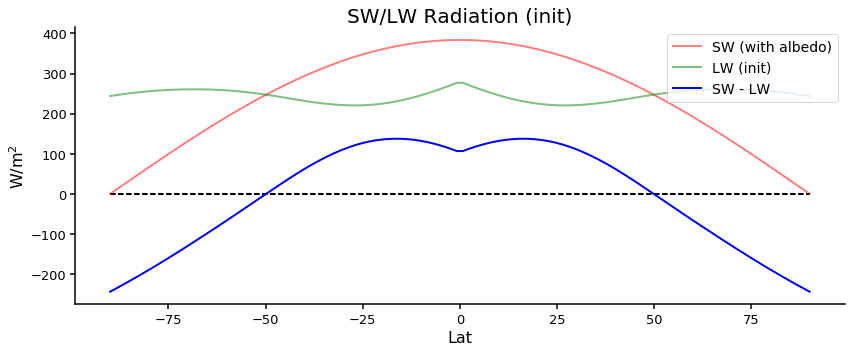

In [36]:
################################################################################
### INITIAL DISTRIBUTIONS
################################################################################
fig, ax = plt.subplots(1, figsize=(12,5))

# radiaiton dist
SW = S*(1 - init_alb)
LW = L(init_temp)
ax.plot([-90, 90], [0, 0], 'k--', lw=2)
ax.plot(lats, SW, 'r', lw=2, label='SW (with albedo)', alpha=0.5)
ax.plot(lats, LW, 'g', lw=2, label='LW (init)', alpha=0.5)
ax.plot(lats, SW - LW, 'b', lw=2, label='SW - LW', alpha=1.0)

ax.set_title('SW/LW Radiation (init)')
ax.set_xlabel('Lat')
ax.set_ylabel('W/m$^2$')
ax.legend(loc='upper right')

plt.tight_layout()

# plt.savefig('init_dists.png', dpi=200)

In [37]:
################################################################################
# SURFACE FLUX
################################################################################
Fs = lambda lat: 0*lat

In [38]:
################################################################################
# NUMERICAL METHODS
################################################################################
# numerical_method = 'euler_for'
# numerical_method = 'euler_back'
numerical_method = 'crank'

In [39]:
################################################################################
# SET UP CRANK-NICOLSON MATRICES
################################################################################
alpha = 0.5

r = D * dt / dy**2

A = np.zeros((len(lats), len(lats)))
B = np.zeros((len(lats), len(lats)))

rng = np.arange(len(lats)-1)

np.fill_diagonal(A, 2 + 2*r)
A[rng, rng+1] = -r   
A[rng+1, rng] = -r   

np.fill_diagonal(B, 2 - 2*r) 
B[rng, rng+1] = r   
B[rng+1, rng] = r   

#insulated boundaries
A[0, 0] = 1; A[0, 1] = -1
A[-1, -2] = 1; A[-1, -1] = -1

B[0, 0] = 1; B[0, 1] = -1
B[-1, -2] = 1; B[-1, -1] = -1

Ainv = np.linalg.inv(A)
C = np.dot(Ainv, B)

In [40]:
################################################################################
### INTEGRATION STEP
################################################################################
def take_step(E, T, alb):
    """
    one step of numerical integration
    """
    if numerical_method == 'euler_for':
        E = E + dt * g/ps * ( (1-alb)*S - L(T) - Fs(lats) ) + dt * D/dy**2 * ( np.roll(E, 1) - 2*E + np.roll(E,-1) )
    elif numerical_method == 'euler_back':
        E = E + dt * g/ps * ( (1-alb)*S - L(T) - Fs(lats) ) + dt * D/dy**2 * ( np.roll(E, 1) - 2*E + np.roll(E,-1) )
        Estar = E + dt * g/ps * ( (1-alb)*S - L(T) - Fs(lats) ) + dt * D/dy**2 * ( np.roll(E, 1) - 2*E + np.roll(E,-1) )
    elif numerical_method == 'crank':
        E = np.dot(C, E) + dt * g/ps * ( (1-alb)*S - L(T) - Fs(lats) )

    E[0] = E[1]
    E[-1] = E[-2]
    T = T_dataset[np.searchsorted(E_dataset, E)]
    if albedo_feedback:
        alb = lats*0 + a2
        alb[np.where(T <= 273.16)] = a1    
    return E, T, alb

In [41]:
################################################################################
### RUN CALCULATION AND SHOW SNAPSHOTS
################################################################################
print("Insolation Type:   {}".format(insolation_type))
if insolation_type == 'perturbed':
    print("    lat0 = {:.0f}, M = {:.0f}, sigma = {:.2f}".format(lat0, M, sigma))
print("Initial Temp Dist: {}".format(init_condition))
print("Albedo Feedback:   {}".format(albedo_feedback))
print("Numerical Method:  {}".format(numerical_method))

T_array = np.zeros((frames, len(lats)))
E_array = np.zeros((frames, len(lats)))
alb_array = np.zeros((frames, len(lats)))

T = init_temp
E = E_dataset[np.searchsorted(T_dataset, T)]
alb = init_alb

t0 = clock()
iter_count = 0
frame_count = 0
error = -1
while iter_count < max_iters:
    if iter_count % 1000 == 0: 
        print('{}/{:.0f} iterations. Last error: {:.5f}'.format(iter_count, max_iters, error))
    if iter_count % Nplot == 0:
        T_array[frame_count, :] = T
        E_array[frame_count, :] = E
        alb_array[frame_count, :] = alb
        error = np.max(np.abs(T_array[frame_count, :] - T_array[frame_count-1, :]))
        if error < tolerance:
            frame_count += 1
            T_array = T_array[:frame_count, :]
            E_array = E_array[:frame_count, :]
            alb_array = alb_array[:frame_count, :]
            print('Equilibrium reached in {} iterations ({:.1f} days).'.format(iter_count, iter_count*dt/60/60/24))
            break
        else:
            frame_count += 1
    E, T, alb = take_step(E, T, alb)
    iter_count += 1

tf = clock()
if T_array.shape[0] == frames:
    print('Failed to reach equilibrium. Final error: {:.16f} K'.format(np.max(np.abs(T_array[-1, :] - T_array[-2, :]))))
print("Time: {:.1f} microseconds/iteration".format((tf-t0)/iter_count*10**6))

Insolation Type:   annual_mean_clark
Initial Temp Dist: triangle
Albedo Feedback:   False
Numerical Method:  crank
0/100000 iterations. Last error: -1.00000
1000/100000 iterations. Last error: 0.32300
2000/100000 iterations. Last error: 0.00200
3000/100000 iterations. Last error: 0.00100
Equilibrium reached in 3100 iterations (470.8 days).
Time: 486640.6 microseconds/iteration


Mean T: 281.3933833341995 K


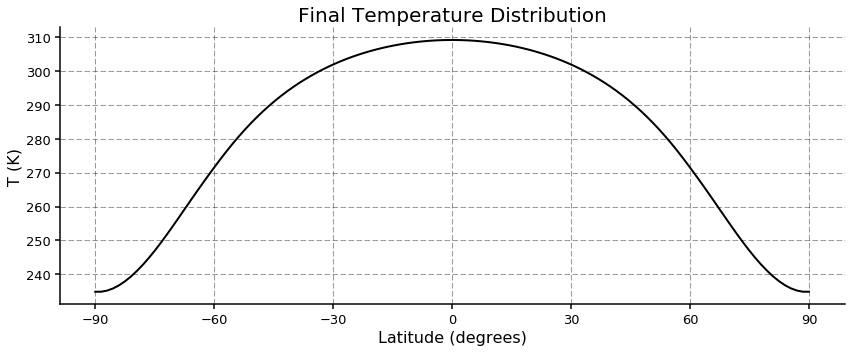

In [42]:
f, ax = plt.subplots(1, figsize=(12,5))
ax.plot(lats, T_array[-1, :], 'k')
ax.set_title("Final Temperature Distribution")
ax.set_xlabel('Latitude (degrees)')
ax.set_ylabel('T (K)')
ax.grid(c='k', ls='--', lw=1, alpha=0.4)
ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
plt.tight_layout()

print('Mean T: {} K'.format(np.mean(T_array[-1,:])))

Approximate lat = 0.8
Root found = 0.0000000000017918 (of 3)
ITCZ = 0.00000


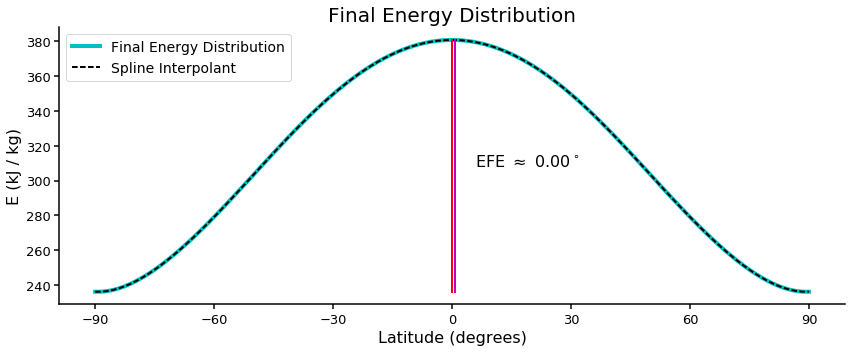

In [43]:
################################################################################
### FIND ITCZ
################################################################################
E_f = E_array[-1, :] / 1000

spl = UnivariateSpline(lats, E_f, k=4, s=0)
roots = spl.derivative().roots()

max_index = np.argmax(E_f)
efe_lat = lats[max_index]

min_error_index = np.argmin( np.abs(roots - efe_lat) )
closest_root = roots[min_error_index]

print("Approximate lat = {:.1f}".format(efe_lat))
print("Root found = {:.16f} (of {})".format(closest_root, len(roots)))

f, ax = plt.subplots(1, figsize=(12,5))
ax.plot(lats, E_f, 'c', label='Final Energy Distribution', lw=4)
ax.plot(lats, spl(lats), 'k--', label='Spline Interpolant')
min_max = [E_f.min(), E_f.max()]
ax.plot([efe_lat, efe_lat], min_max, 'm')
ax.plot([closest_root, closest_root], min_max, 'r')
ax.text(efe_lat+5, np.average(min_max), "EFE $\\approx$ {:.2f}$^\\circ$".format(closest_root), size=16)
# ax.set_title("M = {}, $\\theta_a$ = {}$^\\circ$, $\\sigma$ = {}$^\\circ$".format(M, lat0, sigma))
# ax.set_title("Final Temperature Distribution: Summer Mean Insolation")
ax.set_title("Final Energy Distribution")
ax.legend(fontsize=14, loc="upper left")
ax.set_xlabel('Latitude (degrees)')
ax.set_ylabel('E (kJ / kg)')
ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
plt.tight_layout()

# plt.savefig('cover.png', dpi=200)
# plt.savefig('perturbation_efe.png', dpi=200)
# plt.savefig('summer_mean_efe.png', dpi=200)

print("ITCZ = {:.5f}".format(closest_root*0.64))

(SW - LW) at EFE: 63.711909833268294 W/m^2


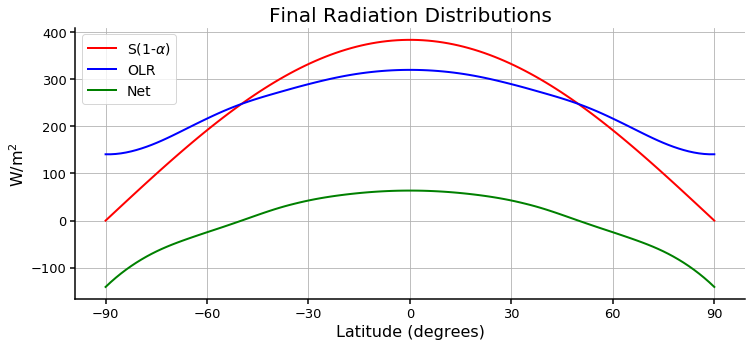

In [44]:
################################################################################
### SHOW FINAL RADIATION DISTRIBUTIONS
################################################################################
f, ax = plt.subplots(1, figsize=(12, 5))

T_f = T_array[-1, :]
alb_f = alb_array[-1, :]
SW_f = S * (1 - alb_f)
LW_f = L(T_f)
ax.plot(lats, SW_f, 'r', label='S(1-$\\alpha$)')
ax.plot(lats, LW_f, 'b', label='OLR')
ax.plot(lats, SW_f - LW_f, 'g', label='Net')
ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
ax.grid()
ax.legend(loc='upper left')
ax.set_title("Final Radiation Distributions")
ax.set_xlabel("Latitude (degrees)")
ax.set_ylabel("W/m$^2$")

# plt.savefig('final_radiation.png', dpi=200)

print('(SW - LW) at EFE: {} W/m^2'.format(SW_f[max_index] - LW_f[max_index]))

Initial Condition:


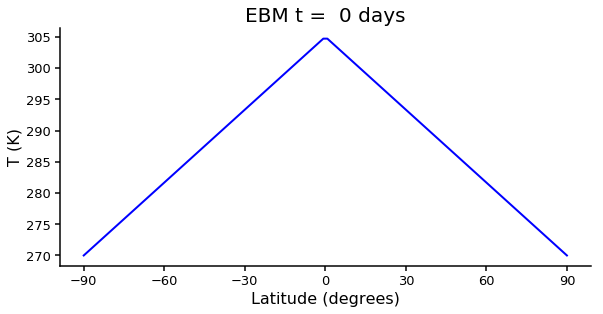

In [45]:
################################################################################
### ANIMATION
################################################################################
show = 'T'
# show = 'E'
# show = 'alb'

# set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(1, figsize=(9,5))

ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])
ax.set_xlabel('Latitude (degrees)')
if show == 'T':
    array = T_array
    ax.set_ylabel('T (K)')
elif show == 'E':
    array = E_array
    ax.set_ylabel("W/m$^2$")
elif show == 'alb':
    array = alb_array
    ax.set_ylabel("$\\alpha$")
ax.set_title('EBM t =  0 days')
plt.tight_layout(pad=3)

print("Initial Condition:")
line, = ax.plot(lats, array[0, :], 'b')

def init():
    line.set_data(lats, array[0, :])
    return (line,)

def animate(i):
    if i%100 == 0: 
        print("{}/{} frames".format(i, len(T_array)))
    ax.set_title('EBM t = {:.0f} days'.format((i+1)*Nplot*dt/60/60/24))
    graph = array[i, :]
    line.set_data(lats, graph)
    m = graph.min()
    M = graph.max()
    ax.set_ylim([m - 0.01*np.abs(m), M + 0.01*np.abs(M)])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(T_array), interval=int(anim_length/len(T_array)), blit=True)

In [46]:
anim

0/32 frames


<xarray.DataArray (longitude: 1, latitude: 120, mid_levels: 30)>
array([[[234.854   , 232.573804, ..., 150.128134, 150.128134],
        [234.854   , 232.573804, ..., 150.128134, 150.128134],
        ...,
        [234.854   , 232.573804, ..., 150.128134, 150.128134],
        [234.854   , 232.573804, ..., 150.128134, 150.128134]]])
Coordinates:
  * longitude   (longitude) float64 0.0
  * latitude    (latitude) float64 -90.0 -88.49 -86.97 -85.46 -83.95 -82.44 ...
  * mid_levels  (mid_levels) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
Attributes:
    units:    degK


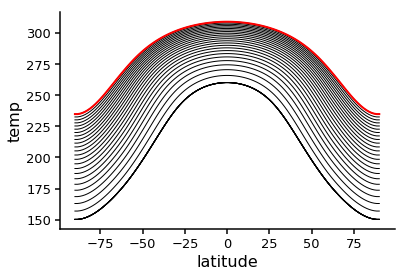

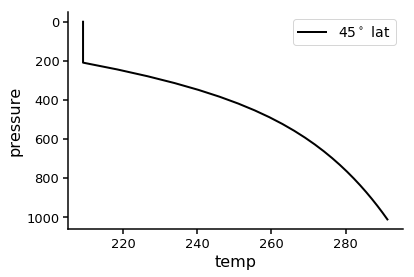

In [47]:
for i in range(nLevels):
    plt.plot(lats, state['air_temperature'].values[0, :, i], 'k-', lw=1.0)
plt.plot(lats, state['air_temperature'].values[0, :, 0], 'r-')
plt.xlabel('latitude')
plt.ylabel('temp')
print(state['air_temperature'])
plt.figure()
lat = 45
plt.plot(state['air_temperature'].values[0, int(lat/dlat), :], pressures/100, 'k-', label='{}$^\\circ$ lat'.format(lat))
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('temp')
plt.ylabel('pressure')

<xarray.DataArray (longitude: 1, latitude: 120, mid_levels: 30)>
array([[[7.684602e-05, 6.155362e-05, ..., 0.000000e+00, 0.000000e+00],
        [7.684602e-05, 6.155362e-05, ..., 0.000000e+00, 0.000000e+00],
        ...,
        [7.684602e-05, 6.155362e-05, ..., 0.000000e+00, 0.000000e+00],
        [7.684602e-05, 6.155362e-05, ..., 0.000000e+00, 0.000000e+00]]])
Coordinates:
  * longitude   (longitude) float64 0.0
  * latitude    (latitude) float64 -90.0 -88.49 -86.97 -85.46 -83.95 -82.44 ...
  * mid_levels  (mid_levels) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
Attributes:
    units:    g/g


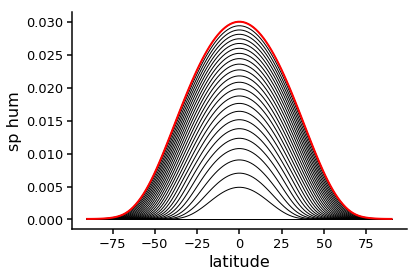

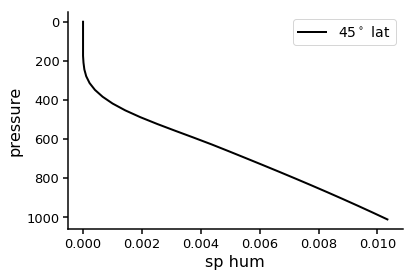

In [48]:
for i in range(nLevels):
    plt.plot(lats, state['specific_humidity'].values[0, :, i], 'k-', lw=1.0)
plt.plot(lats, state['specific_humidity'].values[0, :, 0], 'r-')
plt.xlabel('latitude')
plt.ylabel('sp hum')
print(state['specific_humidity'])
plt.figure()
lat = 45
plt.plot(state['specific_humidity'].values[0, int(lat/dlat), :], pressures/100, 'k-', label='{}$^\\circ$ lat'.format(lat))
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel('sp hum')
plt.ylabel('pressure')

In [49]:
# prescribed_vapor = state['specific_humidity'].values[:, :, :]

A: -418.4821340580727 W/m2, B: 2.356210359826394 W/m2/K


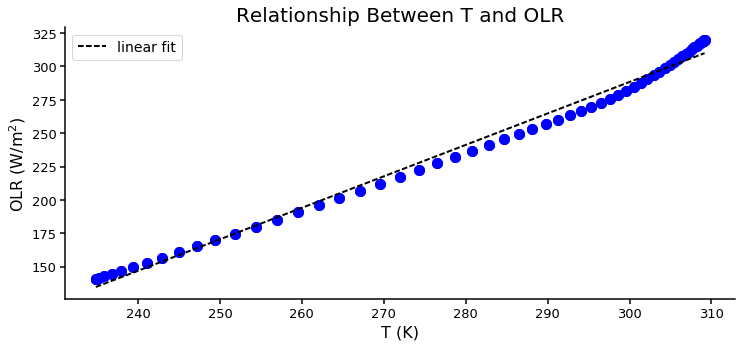

In [50]:
################################################################################
### SHOW LW vs. T
################################################################################
f, ax = plt.subplots(1, figsize=(12, 5))

def f(t, a, b):
    return a + b*t

popt, pcov = curve_fit(f, T_f, LW_f)
print('A: {} W/m2, B: {} W/m2/K'.format(popt[0], popt[1]))

Tvals = np.linspace(np.min(T_f), np.max(T_f), 1000)

ax.plot(T_f, LW_f, 'bo')
ax.plot(Tvals, f(Tvals, *popt), 'k--', label='linear fit')

ax.set_title("Relationship Between T and OLR")
ax.set_xlabel("T (K)")
ax.set_ylabel("OLR (W/m$^2$)")
ax.legend()

# Full OLR, WV Feedback:  !!! same for no WV Feedback
# A: -418.4821340580727 W/m2, B: 2.356210359826394 W/m2/K

In [29]:
# func = lambda tau: tau**(4*R/cp) * np.exp(-tau)
# xx = np.linspace(1e-10, 100, 100)
# yy = np.zeros(100)
# for i in range(100):
#     integral, error = quadrature(func, 0, xx[i], tol=1e-8, rtol=1e-8, maxiter=1000)
#     yy[i] = xx[i]**(-4*R/cp) * integral + np.exp(-xx[i])
# plt.plot(xx, yy)